In [4]:
import pandas as pd 
import numpy as np

from pymutspec.draw import plot_mutspec192, plot_mutspec12
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import spatial

In [5]:
cox1_mut = pd.read_csv('../data/counted_codons_cox1.csv')
cytb_mut = pd.read_csv('../data/counted_codons_cytb.csv')

In [68]:
cox1_mut.head()

,Unnamed: 0,Species,Gene,ExpectedObserved,A[A>G]A,A[A>G]C,A[A>G]G,A[A>G]T,A[C>T]A,A[C>T]C,...,A[G>T]A,A[G>T]G,A[G>T]T,A[T>A]A,A[T>A]C,A[T>A]G,A[T>A]T,A[T>G]A,A[T>G]G,A[T>G]T
0,0,Abbottina_rivularis,COX1,Expected,6.0,7.0,8.0,5.0,11.0,12.0,...,0,0,0,0,0,0,0,0,0,0
1,1,Abbottina_rivularis,COX1,Observed,0.0,0.0,0.0,0.0,3.0,4.0,...,0,0,0,0,0,0,0,0,0,0
2,2,Acanthogobius_hasta,COX1,Expected,2.0,7.0,8.0,3.0,16.0,14.0,...,0,0,0,0,0,0,0,0,0,0
3,3,Acanthogobius_hasta,COX1,Observed,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,4,Acipenser_schrenckii,COX1,Expected,2.0,7.0,8.0,2.0,16.0,13.0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
counted_codons_cox1 = cox1_mut.drop("Gene", axis=1)
counted_codons_cytb = cytb_mut.drop("Gene", axis=1)

_counted_codons_cox1 = counted_codons_cox1.melt(["Species", "ExpectedObserved"], counted_codons_cox1.columns[2:], var_name="Mut")
_counted_codons_cytb = counted_codons_cytb.melt(["Species", "ExpectedObserved"], counted_codons_cytb.columns[2:], var_name="Mut")

mutations_cox1 = _counted_codons_cox1.pivot(index=["Species", "Mut"], columns="ExpectedObserved", values="value").reset_index()
mutations_cytb = _counted_codons_cytb.pivot(index=["Species", "Mut"], columns="ExpectedObserved", values="value").reset_index()



mutations_cox1["RawMutSpec"] = (mutations_cox1["Observed"] / mutations_cox1["Expected"]).fillna(0)
mutations_cox1["RawMutSpec"] = mutations_cox1["RawMutSpec"].replace(np.inf, 0)
mutations_cytb["RawMutSpec"] = (mutations_cytb["Observed"] / mutations_cytb["Expected"]).fillna(0)
mutations_cytb["RawMutSpec"] = mutations_cytb["RawMutSpec"].replace(np.inf, 0)


rawsum_df_cox1 = mutations_cox1.groupby("Species").RawMutSpec.sum().reset_index().rename(columns={"RawMutSpec": "RawMutSpecSum"})
rawsum_df_cytb = mutations_cytb.groupby("Species").RawMutSpec.sum().reset_index().rename(columns={"RawMutSpec": "RawMutSpecSum"})

mutspecs_cox1 = pd.merge(mutations_cox1, rawsum_df_cox1, on="Species")
mutspecs_cox1["MutSpec"] = mutspecs_cox1["RawMutSpec"] / mutspecs_cox1["RawMutSpecSum"]
mutspecs_cytb = pd.merge(mutations_cytb, rawsum_df_cytb, on="Species")
mutspecs_cytb["MutSpec"] = mutspecs_cytb["RawMutSpec"] / mutspecs_cytb["RawMutSpecSum"]

mutspecs_cytb.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec
0,Abbottina_obtusirostris,A[A>C]A,0.0,0.0,0.0,1.088889,0.0
1,Abbottina_obtusirostris,A[A>C]C,0.0,0.0,0.0,1.088889,0.0
2,Abbottina_obtusirostris,A[A>C]G,0.0,0.0,0.0,1.088889,0.0
3,Abbottina_obtusirostris,A[A>C]T,0.0,0.0,0.0,1.088889,0.0
4,Abbottina_obtusirostris,A[A>G]A,8.0,0.0,0.0,1.088889,0.0


### CHANGED TO HEAVY STRAND

In [7]:
def getrevers(mut):
    translator = str.maketrans("ACGT", "TGCA")
    new_mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = new_mut.translate(translator)
    return new_mut

In [8]:
mutspecs_cox1['Mut'] = mutspecs_cox1.Mut.apply(getrevers)
mutspecs_cox1["MutBase"] = mutspecs_cox1.Mut.str.slice(2, 5)
mutspecs_cox1["Context"] = mutspecs_cox1.Mut.str.get(0) + mutspecs_cox1.Mut.str.get(2) + mutspecs_cox1.Mut.str.get(-1)

mutspecs_cytb['Mut'] = mutspecs_cytb.Mut.apply(getrevers)
mutspecs_cytb["MutBase"] = mutspecs_cytb.Mut.str.slice(2, 5)
mutspecs_cytb["Context"] = mutspecs_cytb.Mut.str.get(0) + mutspecs_cytb.Mut.str.get(2) + mutspecs_cytb.Mut.str.get(-1)


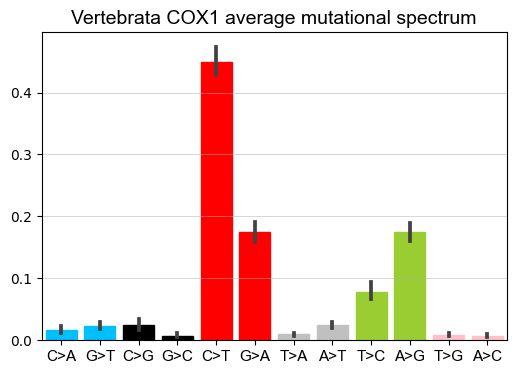

In [9]:
_species_spectra12 = mutspecs_cox1.copy()
_species_spectra12["Mut"] = _species_spectra12["Mut"].str.slice(2,5)
ax = plot_mutspec12(
    _species_spectra12.groupby(["Species", "Mut"]).MutSpec.sum().reset_index(), 
    fontname="Arial", ticksize=11, title="Vertebrata COX1 average mutational spectrum")

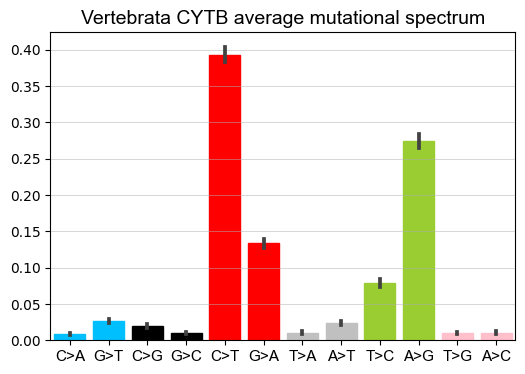

In [10]:
_species_spectra12 = mutspecs_cytb.copy()
_species_spectra12["Mut"] = _species_spectra12["Mut"].str.slice(2,5)
ax = plot_mutspec12(
    _species_spectra12.groupby(["Species", "Mut"]).MutSpec.sum().reset_index(), 
    fontname="Arial", ticksize=11, title="Vertebrata CYTB average mutational spectrum",
    )

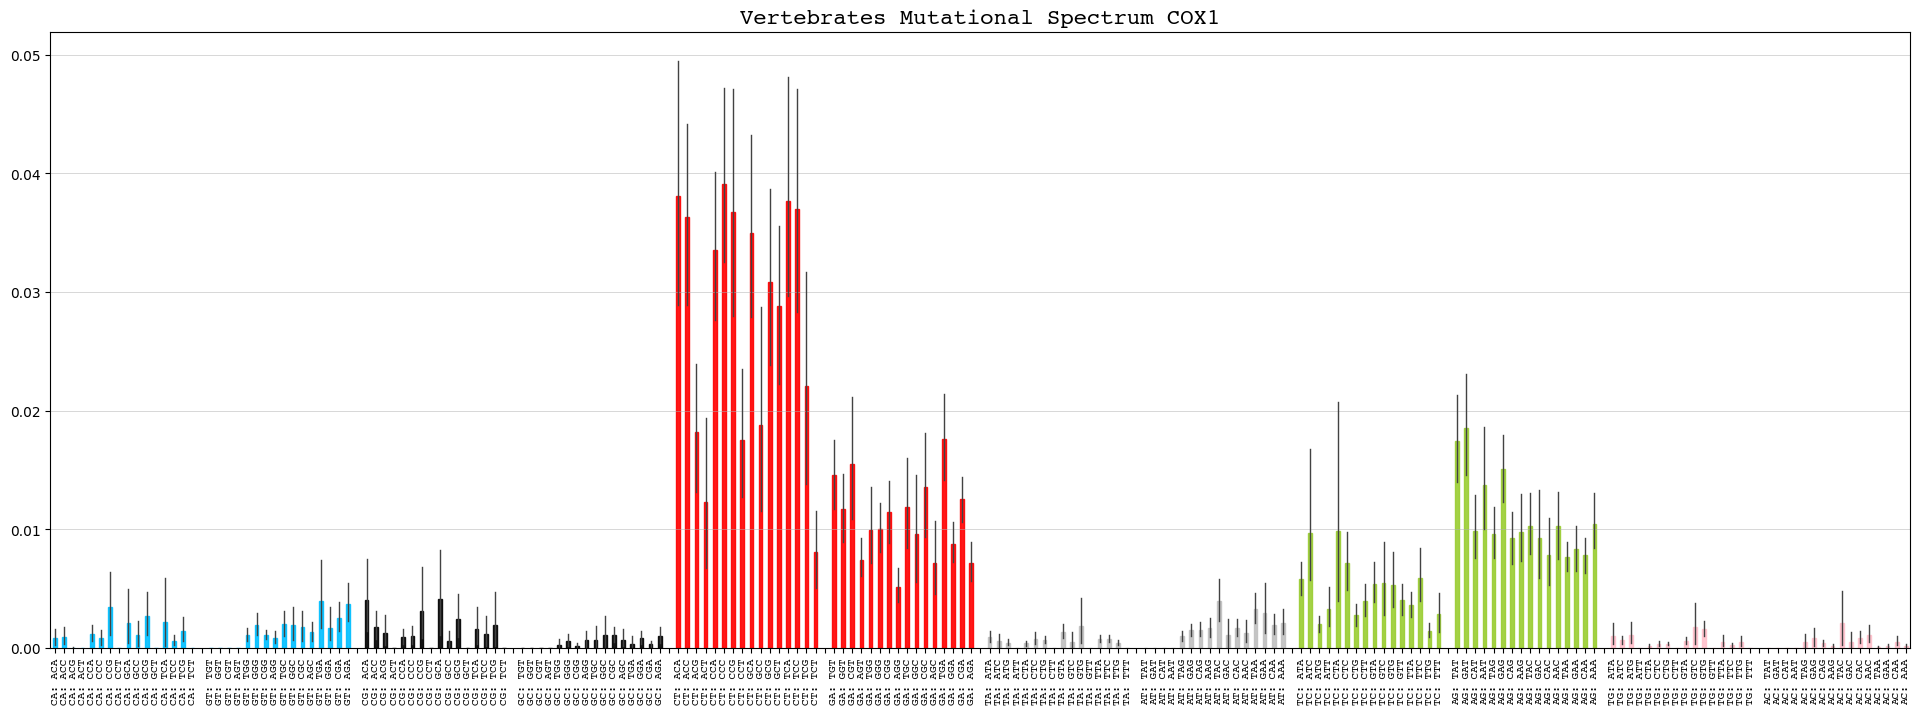

<AxesSubplot:title={'center':'Vertebrates Mutational Spectrum COX1'}>

In [11]:
plot_mutspec192(mutspecs_cox1, title='Vertebrates Mutational Spectrum COX1',
                fontname='Courier', ticksize=8, labels_style='long')

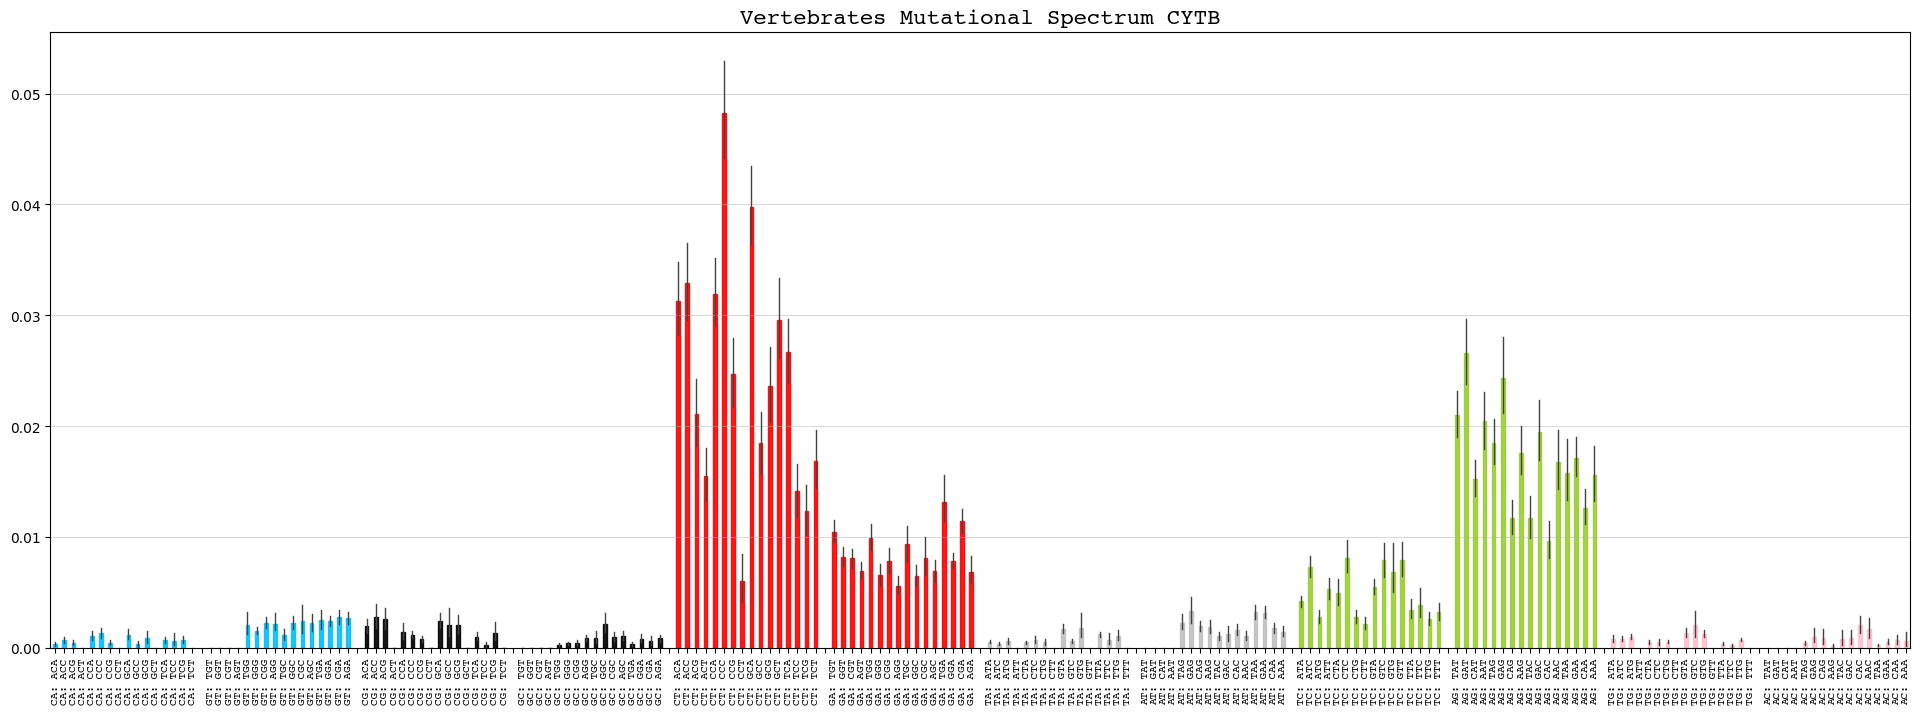

<AxesSubplot:title={'center':'Vertebrates Mutational Spectrum CYTB'}>

In [12]:
plot_mutspec192(mutspecs_cytb, title='Vertebrates Mutational Spectrum CYTB',
                fontname='Courier', ticksize=8, labels_style='long')

In [41]:
ms_all_cox1 = mutspecs_cox1.groupby(['Mut'])['RawMutSpec'].sum().reset_index()
ms_all_cox1["RawMutSpecSum"] = ms_all_cox1.RawMutSpec.sum()

ms_all_cox1['MutSpec'] = ms_all_cox1.RawMutSpec / ms_all_cox1.RawMutSpecSum
ms_all_cox1 = ms_all_cox1.drop(['RawMutSpec', 'RawMutSpecSum'], axis=1)

ms_all_cox1

,Mut,MutSpec
0,A[A>C]A,0.000409
1,A[A>C]C,0.001728
2,A[A>C]G,0.000273
3,A[A>C]T,0.000000
4,A[A>G]A,0.008995
...,...,...
187,T[T>C]T,0.002409
188,T[T>G]A,0.000407
189,T[T>G]C,0.000439
190,T[T>G]G,0.000548


In [42]:
ms_all_cytb = mutspecs_cytb.groupby(['Mut'])['RawMutSpec'].sum().reset_index()
ms_all_cytb["RawMutSpecSum"] = ms_all_cytb.RawMutSpec.sum()

ms_all_cytb['MutSpec'] = ms_all_cytb.RawMutSpec / ms_all_cytb.RawMutSpecSum
ms_all_cytb = ms_all_cytb.drop(['RawMutSpec', 'RawMutSpecSum'], axis=1)

ms_all_cytb

,Mut,MutSpec
0,A[A>C]A,0.000405
1,A[A>C]C,0.001382
2,A[A>C]G,0.000193
3,A[A>C]T,0.000000
4,A[A>G]A,0.014274
...,...,...
187,T[T>C]T,0.002882
188,T[T>G]A,0.000475
189,T[T>G]C,0.000352
190,T[T>G]G,0.000848


In [46]:
1 - spatial.distance.cosine(ms_all_cytb.MutSpec, ms_all_cox1.MutSpec)

0.9499310795503926

# Work with BE data (FULL)

In [ ]:
def getrevers(mut):
    translator = str.maketrans("ACGT", "TGCA")
    new_mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = new_mut.translate(translator)
    return new_mut

In [113]:
def normol_mutspec_be(raw_data:pd.DataFrame, gene:str):

    raw_data_one_gene = raw_data.drop('Unnamed: 0', axis=1)

    raw_data_one_gene = raw_data_one_gene[raw_data_one_gene.Gene == gene]

    raw_data_one_gene['ExpNum'] = np.where(raw_data_one_gene['ExpNum'] < 0.99, 0, raw_data_one_gene['ExpNum'])
    raw_data_one_gene['ObsNum'] = np.where(raw_data_one_gene['ObsNum'] < 0.99, 0, raw_data_one_gene['ObsNum'])

    ### Norm again
    raw_data_one_gene["RawMutSpec"] = (raw_data_one_gene["ObsNum"] / raw_data_one_gene["ExpNum"]).fillna(0)
    raw_data_one_gene["RawMutSpec"] = raw_data_one_gene["RawMutSpec"].replace(np.inf, 0)
    rawsum_df = raw_data_one_gene.groupby("Species").RawMutSpec.sum().reset_index().rename(columns={"RawMutSpec": "RawMutSpecSum"})
    raw_data_one_gene = pd.merge(raw_data_one_gene, rawsum_df, on="Species")
    raw_data_one_gene["MutSpec"] = raw_data_one_gene["RawMutSpec"] / raw_data_one_gene["RawMutSpecSum"]
    raw_data_one_gene['Mut'] = raw_data_one_gene.Mut.apply(getrevers) # change annotation to heavy STRAND
    raw_data_one_gene["MutBase"] = raw_data_one_gene.Mut.str.slice(2, 5)
    raw_data_one_gene["Context"] = raw_data_one_gene.Mut.str.get(0) + raw_data_one_gene.Mut.str.get(2) + raw_data_one_gene.Mut.str.get(-1)

    return raw_data_one_gene

In [114]:
be_mutspec = pd.read_csv('../data/external/raw_spectum192.csv')

cytb_new_ms = normol_mutspec_be(be_mutspec, gene='Cytb')
cox1_new_ms = normol_mutspec_be(be_mutspec, gene='CO1')

In [115]:
cytb_new_ms.head()

,Mut,ObsNum,ExpNum,MutSpec,Species,Gene,RawMutSpec,RawMutSpecSum,MutBase,Context
0,G[T>C]T,0.00000,2.99513,0.000000,Aulacorhynchus_haematopygus,Cytb,0.000000,9.405286,T>C,GTT
1,T[G>A]T,0.99706,4.77733,0.022190,Aulacorhynchus_haematopygus,Cytb,0.208707,9.405286,G>A,TGT
2,C[G>A]T,0.99898,3.11104,0.034141,Aulacorhynchus_haematopygus,Cytb,0.321108,9.405286,G>A,CGT
3,T[A>G]T,0.99983,0.00000,0.000000,Aulacorhynchus_haematopygus,Cytb,0.000000,9.405286,A>G,TAT
4,G[A>G]T,0.99879,0.00000,0.000000,Aulacorhynchus_haematopygus,Cytb,0.000000,9.405286,A>G,GAT


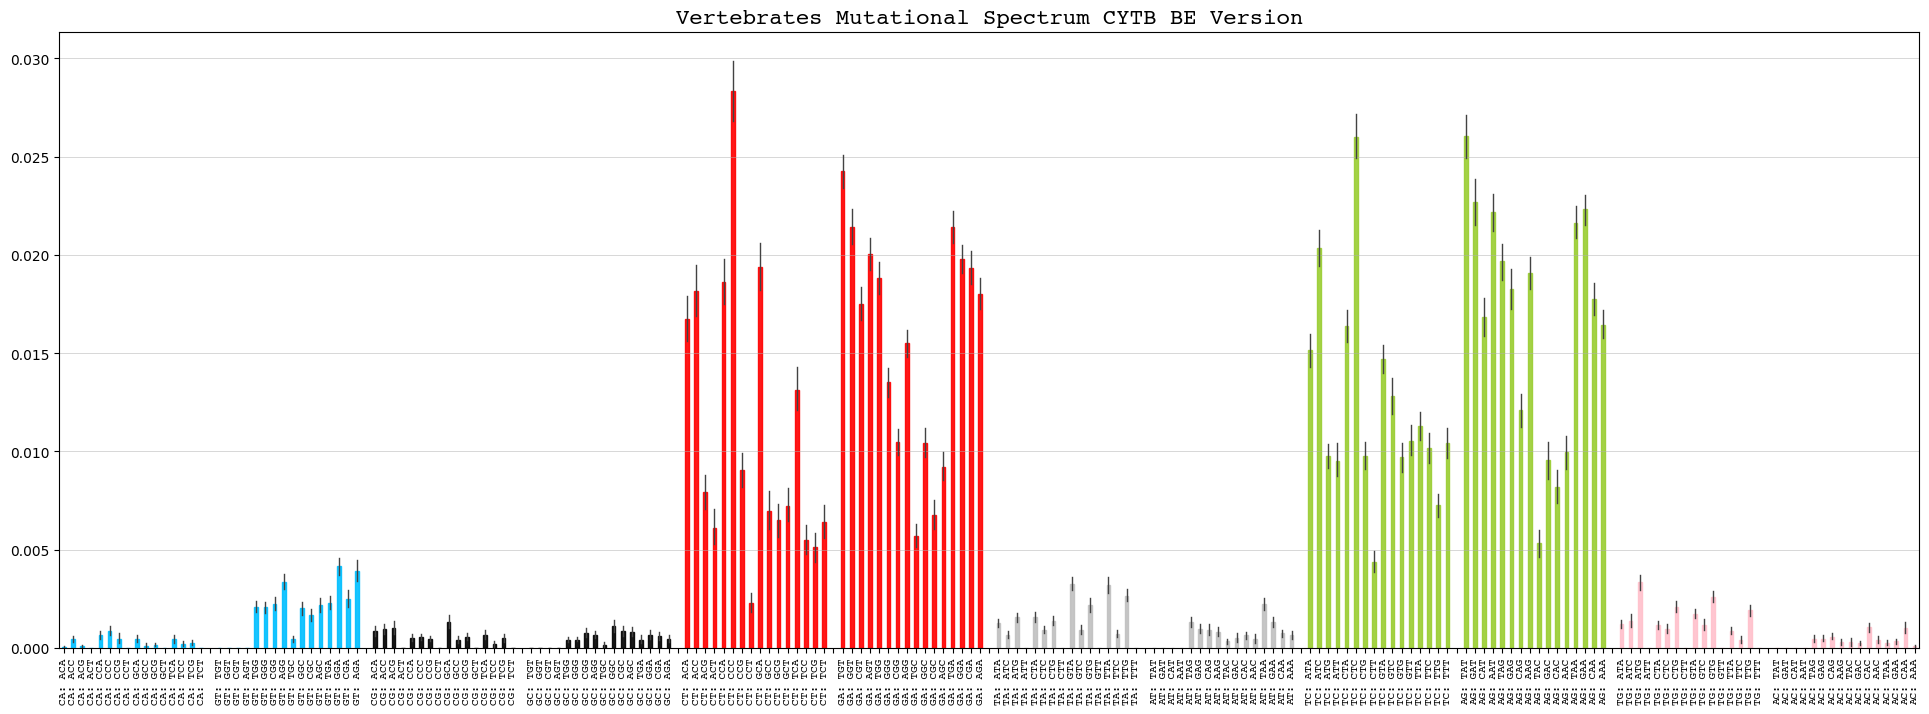

<AxesSubplot:title={'center':'Vertebrates Mutational Spectrum CYTB BE Version'}>

In [116]:
plot_mutspec192(cytb_new_ms, title='Vertebrates Mutational Spectrum CYTB BE Version',
                fontname='Courier', ticksize=8, labels_style='long')

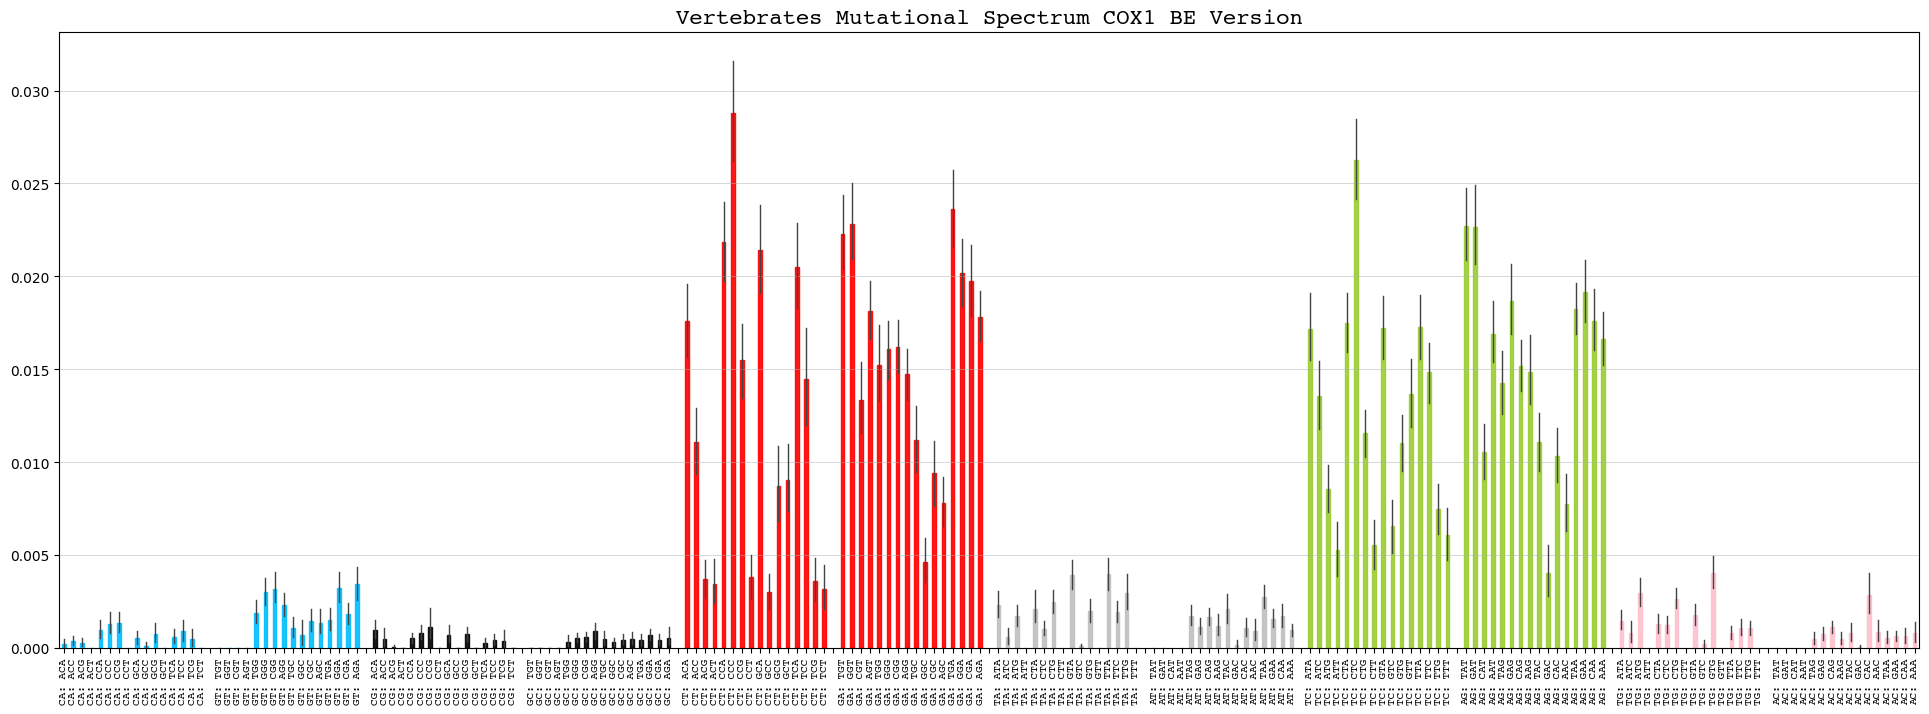

<AxesSubplot:title={'center':'Vertebrates Mutational Spectrum COX1 BE Version'}>

In [107]:
plot_mutspec192(cox1_new_ms, title='Vertebrates Mutational Spectrum COX1 BE Version',
                fontname='Courier', ticksize=8, labels_style='long')

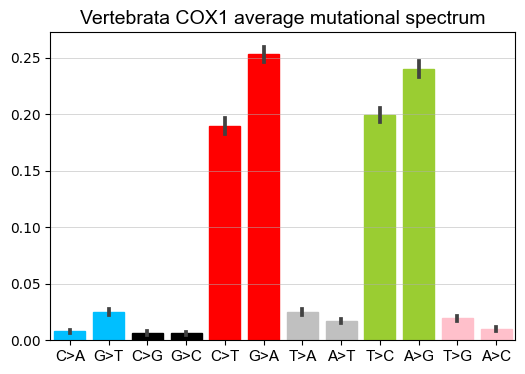

In [117]:
_species_spectra12 = cox1_new_ms.copy()
_species_spectra12["Mut"] = _species_spectra12["Mut"].str.slice(2,5)
ax = plot_mutspec12(
    _species_spectra12.groupby(["Species", "Mut"]).MutSpec.sum().reset_index(), 
    fontname="Arial", ticksize=11, title="Vertebrata COX1 average mutational spectrum",
    )

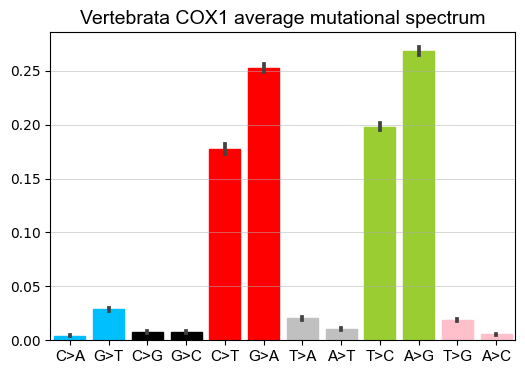

In [118]:
_species_spectra12 = cytb_new_ms.copy()
_species_spectra12["Mut"] = _species_spectra12["Mut"].str.slice(2,5)
ax = plot_mutspec12(
    _species_spectra12.groupby(["Species", "Mut"]).MutSpec.sum().reset_index(), 
    fontname="Arial", ticksize=11, title="Vertebrata COX1 average mutational spectrum",
    )

# Try to filter data for COX1 mb CCC>CTC would be greater

In [ ]:
cox1_mut = pd.read_csv('../data/counted_codons_cox1.csv')